## 1. Install & Load Packages

In [87]:
pip install pandas-datareader

Note: you may need to restart the kernel to use updated packages.


In [182]:
import numpy as np
import pandas_datareader.data as web
import pandas_datareader as web 

import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error

import re

## 2. Load Data

In [89]:
np.random.seed(0)
date_rng = pd.date_range(start="2021-01-01", periods=365, freq="D")
data = np.sin(np.arange(365) * 2 * np.pi / 365) + np.random.normal(0, 0.5, 365)
btc = pd.DataFrame({'Date':date_rng,'BTC-USD':data})

btc.Date = pd.to_datetime(btc['Date'], format='%Y-%m-%d')
btc.set_index('Date', inplace=True)
btc.tail()

,BTC-USD
Date,
2021-12-27,0.263264
2021-12-28,-0.066917
2021-12-29,0.414305
2021-12-30,0.135561
2021-12-31,-0.025054


In [319]:
def extract_number(text):
    # Regex pattern to match digits
    pattern = r'\d+'
    # Find all sequences of digits in the text
    matches = re.findall(pattern, text)
    if matches:
        # Return the first matched sequence of digits as an integer
        return int(matches[0])
    else:
        # Return None if no digits are found
        return None

def cleaning_data(df):

    #drop geoid column
    if 'GEOID' in df.columns.to_list():
        df.drop(columns='GEOID', inplace=True)
    #transpose data
    df = df.T
    #set first row as column name
    new_columns = df[df.index == 'NAME'].iloc[0].to_list()
    df.columns = new_columns
    df = df[1:]
    #datetime index
    df.reset_index(inplace=True)
    df['index'] = df['index'].apply(extract_number)
    df['index'] = pd.to_datetime(df['index'], format='%Y')
    df.set_index('index', inplace=True)
    #interpolate missing value
    for column in df.columns.to_list():
        df[column] = pd.to_numeric(df[column], errors='coerce')
        df[column] = df[column].interpolate()
        df[column] = df[column].bfill()
    
    return(df)

In [320]:
#soybean
ET_soybean = cleaning_data(pd.read_csv('data/soybean_past/2000-2023_Soybean_ET.csv'))
LST_DAY_soybean = cleaning_data(pd.read_csv('data/soybean_past/2000-2023_Soybean_LST_DAY.csv'))
LST_NIGHT_soybean = cleaning_data(pd.read_csv('data/soybean_past/2000-2023_Soybean_LST_NIGHT.csv'))
NDVI_soybean = cleaning_data(pd.read_csv('data/soybean_past/2000-2023_Soybean_NDVI.csv'))
PA_soybean = cleaning_data(pd.read_csv('data/soybean_past/2000-2023_Soybean_PA.csv'))
PAR_soybean = cleaning_data(pd.read_csv('data/soybean_past/2000-2023_Soybean_PAR.csv'))

#corn
@ET_corn = cleaning_data(pd.read_csv('data/corn_past/ET_2000_2023.csv', sep=';'))
@LST_DAY_corn = cleaning_data(pd.read_csv('data/corn_past/LST_DAY_2000_2023.csv', sep=';'))
LST_NIGHT_corn = cleaning_data(pd.read_csv('data/corn_past/LST_NIGHT_2000_2023.csv', sep=';'))
@NDVI_corn = cleaning_data(pd.read_csv('data/corn_past/NDVI_2000_2023.csv', sep=';'))
@PA_corn = cleaning_data(pd.read_csv('data/corn_past/PA_2000_2023.csv', sep=';'))
@PAR_corn = cleaning_data(pd.read_csv('data/corn_past/PAR_2000_2023.csv', sep=';'))

#wheat
ET_wheat = cleaning_data(pd.read_csv('data/wheat_past/wheat_ET_2000-2023.csv'))
SAR_wheat = cleaning_data(pd.read_csv('data/wheat_past/SAR_wheat_2015-2023.csv'))
LST_NIGHT_corn = cleaning_data(pd.read_csv('data/wheat_past/wheat_LST_NIGHT_2000-2023.csv'))
@NDVI_wheat = cleaning_data(pd.read_csv('data/wheat_past/wheat_NDVI_2000-2023.csv', sep=';'))
@PAR_wheat = cleaning_data(pd.read_csv('data/wheat_past/wheat_PAR_2000-2023.csv', sep=';'))
SM_wheat = cleaning_data(pd.read_csv('data/wheat_past/wheat_Soil_Moisture_pm_2015-2023.csv'))

In [340]:
SM_wheat

,Grand Forks,Stutsman,Sioux,Morton,Burleigh,Oliver,Ward,McHenry,Renville,Williams,Stark,Cass,Richland,Pembina,Walsh,Cavalier,Towner,Ramsey,Nelson,Benson,Eddy,Griggs,Steele,Foster,Barnes,Traill,Sargent,Dickey,LaMoure,Ransom,Logan,Kidder,McIntosh,Grant,Emmons,McLean,Mercer,Mountrail,Sheridan,Wells,Pierce,Rolette,Bottineau,Burke,Divide,McKenzie,Billings,Golden Valley,Slope,Dunn,Hettinger,Adams,Bowman
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01,0.205381,0.252169,0.174487,0.183757,0.221467,0.192562,0.238125,0.228823,0.218186,0.161946,0.163834,0.224758,0.222814,0.199302,0.209958,0.182190,0.220745,0.261063,0.251781,0.259323,0.223471,0.234915,0.202663,0.227061,0.234029,0.197104,0.242153,0.254832,0.241557,0.233779,0.238518,0.258835,0.231876,0.169998,0.195962,0.220506,0.190393,0.222586,0.244408,0.203051,0.244598,0.235718,0.225359,0.232348,0.225829,0.151948,0.159520,0.159178,0.166768,0.169361,0.168307,0.165660,0.168246
2016-01-01,0.216213,0.233538,0.145552,0.161847,0.209432,0.172285,0.204179,0.199692,0.182478,0.161655,0.142695,0.171291,0.162570,0.235387,0.236387,0.209884,0.228881,0.258773,0.250904,0.256260,0.219017,0.225074,0.196714,0.208957,0.210012,0.180465,0.209384,0.221897,0.215053,0.190601,0.233203,0.248691,0.225697,0.142984,0.185105,0.197218,0.168046,0.198535,0.225572,0.197028,0.234464,0.236937,0.188186,0.200125,0.204131,0.140150,0.147295,0.141620,0.136223,0.153233,0.140096,0.133475,0.132127
2017-01-01,0.196929,0.235005,0.140892,0.147710,0.195112,0.162360,0.193209,0.187966,0.183952,0.138931,0.125244,0.163523,0.192244,0.177577,0.194714,0.186716,0.213546,0.245824,0.240626,0.252239,0.224749,0.228885,0.199382,0.222587,0.203115,0.177715,0.219814,0.221354,0.207342,0.198926,0.222814,0.243320,0.214944,0.128169,0.173213,0.184112,0.148952,0.195711,0.218977,0.198677,0.229699,0.222589,0.188696,0.198148,0.190628,0.127793,0.130493,0.113619,0.116320,0.135578,0.118863,0.112913,0.112343
2018-01-01,0.187333,0.238482,0.151179,0.162236,0.202188,0.166268,0.185987,0.180483,0.166166,0.161120,0.141159,0.177763,0.194443,0.146629,0.168423,0.165187,0.201908,0.230770,0.225790,0.242643,0.210664,0.218074,0.187029,0.207131,0.222344,0.180522,0.227289,0.215639,0.227474,0.211065,0.240594,0.247382,0.227381,0.147973,0.185499,0.185833,0.163022,0.193133,0.220014,0.190185,0.222059,0.215903,0.168163,0.194575,0.187110,0.152025,0.140246,0.135927,0.148148,0.141502,0.145283,0.142380,0.146272
2019-01-01,0.217961,0.279251,0.195985,0.186320,0.241471,0.194319,0.205472,0.193700,0.178742,0.173677,0.169514,0.231440,0.232625,0.159179,0.191869,0.174575,0.203142,0.241443,0.254050,0.255625,0.242857,0.248429,0.230256,0.239069,0.269159,0.227290,0.290850,0.290975,0.286314,0.264371,0.266908,0.276793,0.262786,0.171315,0.214540,0.204795,0.184525,0.212621,0.241831,0.223090,0.229762,0.225639,0.179972,0.203169,0.192957,0.168855,0.169544,0.161120,0.173497,0.171316,0.170185,0.168424,0.173513
2020-01-01,0.241001,0.288233,0.151126,0.152594,0.217620,0.163988,0.227066,0.219878,0.215900,0.152422,0.143089,0.240212,0.218606,0.213278,0.226400,0.211715,0.248892,0.284066,0.274638,0.281626,0.275509,0.270065,0.244771,0.272237,0.275136,0.249989,0.265737,0.269059,0.273647,0.255348,0.239854,0.284220,0.243519,0.138610,0.193423,0.203675,0.156840,0.211752,0.260285,0.247545,0.250165,0.253327,0.225551,0.198216,0.192693,0.138087,0.144796,0.142716,0.146117,0.146412,0.142604,0.137919,0.143397
2021-01-01,0.152929,0.231011,0.151047,0.158035,0.193603,0.162295,0.186452,0.173300,0.166952,0.140497,0.153121,0.128771,0.147924,0.140715,0.154793,0.163363,0.198045,0.216577,0.209084,0.237769,0.213039,0.189615,0.154035,0.188228,0.187183,0.124738,0.198310,0.218281,0.220218,0.178269,0.248394,0.257610,0.214204,0.150019,0.177524,0.169424,0.154762,0.182224,0.220193,0.182625,0.210987,0.205730,0.161963,0.184832,0.166371,0.135477,0.150654,0.126582,0.137404,0.152653,0.152088,0.141709,0.132438
2022-01-01,0.261477,0.292537,0.162171,0.172424,0.206937,0.177715,0.240735,0.229794,0.258407,0.206174,0.185571,0.241574,0.233

(array([18628., 18687., 18748., 18809., 18871., 18932., 18993.]),
 [Text(18628.0, 0, '2021-01'),
  Text(18687.0, 0, '2021-03'),
  Text(18748.0, 0, '2021-05'),
  Text(18809.0, 0, '2021-07'),
  Text(18871.0, 0, '2021-09'),
  Text(18932.0, 0, '2021-11'),
  Text(18993.0, 0, '2022-01')])

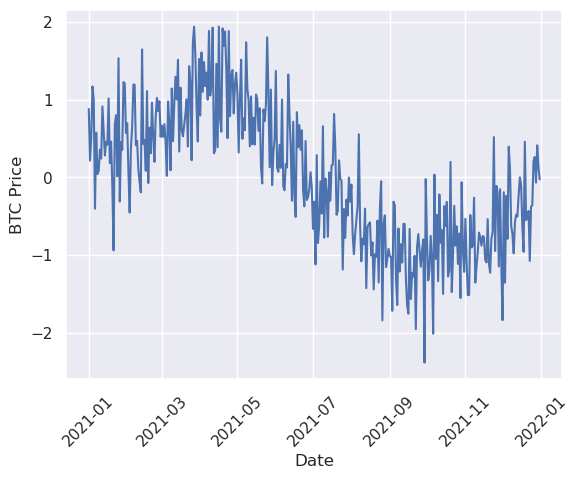

In [90]:
sns.set()

plt.plot(btc.index, btc['BTC-USD'], )

plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)

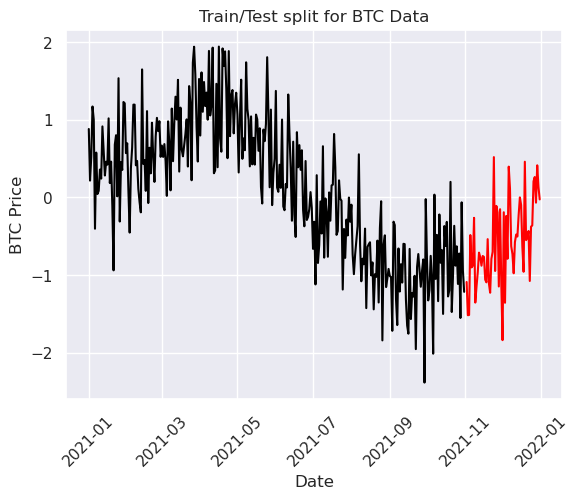

In [91]:
train = btc[btc.index < pd.to_datetime("2021-11-01", format='%Y-%m-%d')]
test = btc[btc.index > pd.to_datetime("2021-11-01", format='%Y-%m-%d')]

plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for BTC Data")
plt.show()

In [92]:
y = train['BTC-USD']

## 3. Modeling SARIMA

In [116]:
SARIMAXmodel = SARIMAX(y, order = (2, 2, 2), seasonal_order=(2,2,2,12))
SARIMAXmodel = SARIMAXmodel.fit()

/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.59530D+00    |proj g|=  2.22140D-01


 This problem is unconstrained.



At iterate    5    f=  1.11840D+00    |proj g|=  4.60017D-02

At iterate   10    f=  1.10869D+00    |proj g|=  5.37039D-03

At iterate   15    f=  1.06654D+00    |proj g|=  2.30925D-01

At iterate   20    f=  9.83098D-01    |proj g|=  7.22321D-02

At iterate   25    f=  9.73724D-01    |proj g|=  2.16433D-03

At iterate   30    f=  9.71063D-01    |proj g|=  2.47353D-02

At iterate   35    f=  9.68698D-01    |proj g|=  3.31404D-03

At iterate   40    f=  9.68664D-01    |proj g|=  1.17843D-03

At iterate   45    f=  9.68600D-01    |proj g|=  2.66174D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     49     68   

In [120]:
len(test.index)

60

In [118]:
y_pred3 = SARIMAXmodel.get_forecast(len(test.index))
y_pred3

In [119]:
y_pred_df3 = y_pred3.conf_int(alpha = 0.05) 
y_pred_df3

,lower BTC-USD,upper BTC-USD
2021-11-01,-1.342926,1.127470
2021-11-02,-2.142490,0.328053
2021-11-03,-2.033792,0.444090
2021-11-04,-1.270100,1.216526
2021-11-05,-1.855000,0.640524
2021-11-06,-1.719218,0.785582
2021-11-07,-2.283207,0.231254
2021-11-08,-1.671446,0.853104
2021-11-09,-2.113231,0.416338
2021-11-10,-1.222144,1.318303


In [121]:
y_pred_df3["Predictions"] = SARIMAXmodel.predict(start = y_pred_df3.index[0], end = y_pred_df3.index[-1])
y_pred_df3

,lower BTC-USD,upper BTC-USD,Predictions
2021-11-01,-1.342926,1.127470,-0.107728
2021-11-02,-2.142490,0.328053,-0.907219
2021-11-03,-2.033792,0.444090,-0.794851
2021-11-04,-1.270100,1.216526,-0.026787
2021-11-05,-1.855000,0.640524,-0.607238
2021-11-06,-1.719218,0.785582,-0.466818
2021-11-07,-2.283207,0.231254,-1.025977
2021-11-08,-1.671446,0.853104,-0.409171
2021-11-09,-2.113231,0.416338,-0.848447
2021-11-10,-1.222144,1.318303,0.048079


In [123]:
y_pred_df3.index = test.index
y_pred_df3

,lower BTC-USD,upper BTC-USD,Predictions
Date,,,
2021-11-02,-1.342926,1.127470,-0.107728
2021-11-03,-2.142490,0.328053,-0.907219
2021-11-04,-2.033792,0.444090,-0.794851
2021-11-05,-1.270100,1.216526,-0.026787
2021-11-06,-1.855000,0.640524,-0.607238
2021-11-07,-1.719218,0.785582,-0.466818
2021-11-08,-2.283207,0.231254,-1.025977
2021-11-09,-1.671446,0.853104,-0.409171
2021-11-10,-2.113231,0.416338,-0.848447


In [125]:
y_pred_out3 = y_pred_df3["Predictions"] 
y_pred_out3

Date
2021-11-02   -0.107728
2021-11-03   -0.907219
2021-11-04   -0.794851
2021-11-05   -0.026787
2021-11-06   -0.607238
2021-11-07   -0.466818
2021-11-08   -1.025977
2021-11-09   -0.409171
2021-11-10   -0.848447
2021-11-11    0.048079
2021-11-12   -1.114868
2021-11-13   -1.085366
2021-11-14    0.219399
2021-11-15   -0.709432
2021-11-16   -0.847638
2021-11-17    0.162924
2021-11-18   -0.400064
2021-11-19   -0.198528
2021-11-20   -0.884239
2021-11-21   -0.143495
2021-11-22   -0.949140
2021-11-23    0.414872
2021-11-24   -0.523750
2021-11-25   -0.809807
2021-11-26    0.505241
2021-11-27   -0.642809
2021-11-28   -0.308782
2021-11-29    0.460849
2021-11-30   -0.116866
2021-12-01   -0.002213
2021-12-02   -0.523280
2021-12-03   -0.011492
2021-12-04   -0.574388
2021-12-05    0.624120
2021-12-06   -0.644173
2021-12-07   -0.679713
2021-12-08    0.666414
2021-12-09   -0.046169
2021-12-10   -0.352888
2021-12-11    0.823659
2021-12-12    0.234767
2021-12-13    0.391464
2021-12-14   -0.364324
2021-1

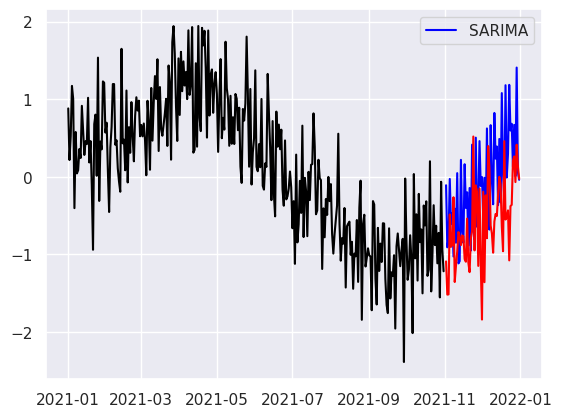

In [115]:
plt.plot(train, color = "black")
#plt.plot(y_pred_out1, color='green', label = 'ARMA')
#plt.plot(y_pred_out2, color='Yellow', label = 'ARIMA')
plt.plot(y_pred_out3, color='blue', label = 'SARIMA')
plt.plot(test, color = "red")
plt.legend()

In [102]:
arma_rmse = np.sqrt(mean_squared_error(test["BTC-USD"].values, y_pred_df3["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  0.8804517649257403
